In [ ]:
pip install autokeras

     |████████████████████████████████| 174kB 13.7MB/s 
     |████████████████████████████████| 71kB 10.8MB/s 
  Created wheel for keras-tuner: filename=keras_tuner-1.0.2-cp36-none-any.whl size=78939 sha256=8b3597bd95f7a449d52ccd2dd9d15fb2c427594319448c227e02cf50a772f113
  Stored in directory: /root/.cache/pip/wheels/bb/a1/8a/7c3de0efb3707a1701b36ebbfdbc4e67aedf6d4943a1f463d6
  Created wheel for terminaltables: filename=terminaltables-3.1.0-cp36-none-any.whl size=15358 sha256=51a38a26c2992c5acb1487149c931804ad0c46cb342407c4d7f7e8735f691f85
  Stored in directory: /root/.cache/pip/wheels/30/6b/50/6c75775b681fb36cdfac7f19799888ef9d8813aff9e379663e
Successfully built keras-tuner terminaltables


In [ ]:
import kerastuner as kt

## Load data

In [ ]:
# Import the dataset loading function from sklearn
from sklearn.datasets import load_digits

# Load the hand-written digits dataset
digits = load_digits()

# Get the images and corresponding labels
images, labels = digits.images, digits.target
images.shape, labels.shape

((1797, 8, 8), (1797,))

## Exploratory data analysis & Data preprocessing &  feature engineering

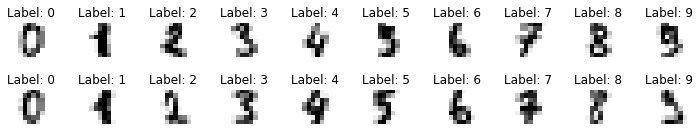

In [ ]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

# plot first 20 images
n = 20
_, axes = plt.subplots(2, 10, figsize=(10, 2))
plt.tight_layout()
for i in range(n):
    row, col = i // 10, i % 10
    axes[row, col].set_axis_off()
    axes[row, col].imshow(images[i,], cmap=plt.cm.gray_r, interpolation='nearest')
    axes[row, col].set_title('Label: %i' % labels[i])

In [ ]:
# reshape images to vectors
n_samples = len(digits.images)
X = digits.images.reshape((n_samples, -1))
X.shape

(1797, 64)

In [ ]:
# Split data into train and test subsets
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X, labels, test_size=0.2, shuffle=False)

print("Shape of the training data: {}".format(X_train.shape))
print("Shape of the testing data: {}".format(X_test.shape))

Shape of the training data: (1437, 64)
Shape of the testing data: (360, 64)


In [ ]:
X_train.shape, X_test.shape

((1437, 64), (360, 64))

## KerasTuner tuning: joint hyperparameter tuning and model selection

In [ ]:
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from kerastuner.engine import hyperparameters as hp


def build_model(hp):
    model_type = hp.Choice('model_type', ['svm', 'random_forest'])
    if model_type == 'svm':
        with hp.conditional_scope('model_type', 'svm'):
            model = SVC(C=hp.Float('C', 1e-3, 10, sampling='linear', default=1),
                        kernel=hp.Choice("kernel_type", ['linear', 'rbf'], default="linear"), 
                        random_state=42)
    elif model_type == 'random_forest':
        with hp.conditional_scope('model_type', 'random_forest'):
            model =  RandomForestClassifier(
                n_estimators=hp.Int('n_estimators', 10, 200, step=10),
                max_depth=hp.Int('max_depth', 3, 10))
    else:
        raise ValueError('Unrecognized model_type')
    return model



### Random Search Algorithm

In [ ]:
from sklearn.model_selection import KFold

random_tuner = kt.tuners.Sklearn(
        oracle=kt.oracles.RandomSearch(
            objective=kt.Objective('score', 'max'),
            max_trials=30,
            seed=42),
        hypermodel=build_model,
        cv=KFold(3, shuffle=False, random_state=42),
        overwrite=True,
        project_name='random_tuner')

random_tuner.search(X_train, y_train)

Trial 30 Complete [00h 00m 00s]
score: 0.8983994432846206

Best score So Far: 0.9693806541405707
Total elapsed time: 00h 00m 11s
INFO:tensorflow:Oracle triggered exit


In [ ]:
random_tuner.search_space_summary()

Search space summary
Default search space size: 5
model_type (Choice)
{'default': 'svm', 'conditions': [], 'values': ['svm', 'random_forest'], 'ordered': False}
C (Float)
{'default': 1, 'conditions': [{'class_name': 'Parent', 'config': {'name': 'model_type', 'values': ['svm']}}], 'min_value': 0.001, 'max_value': 10.0, 'step': None, 'sampling': 'linear'}
kernel_type (Choice)
{'default': 'linear', 'conditions': [{'class_name': 'Parent', 'config': {'name': 'model_type', 'values': ['svm']}}], 'values': ['linear', 'rbf'], 'ordered': False}
n_estimators (Int)
{'default': None, 'conditions': [{'class_name': 'Parent', 'config': {'name': 'model_type', 'values': ['random_forest']}}], 'min_value': 10, 'max_value': 200, 'step': 10, 'sampling': None}
max_depth (Int)
{'default': None, 'conditions': [{'class_name': 'Parent', 'config': {'name': 'model_type', 'values': ['random_forest']}}], 'min_value': 3, 'max_value': 10, 'step': 1, 'sampling': None}


In [ ]:
random_tuner.results_summary(1)

Results summary
Results in ./random_tuner
Showing 1 best trials
Objective(name='score', direction='max')
Trial summary
Hyperparameters:
model_type: svm
C: 2.242630562998417
kernel_type: rbf
Score: 0.9693806541405707


In [ ]:
# Evaluate the best discovered model
from sklearn.metrics import accuracy_score

best_model = random_tuner.get_best_models(1)[0]
best_model.fit(X_train, y_train)
y_pred_test = best_model.predict(X_test)
test_acc = accuracy_score(y_test, y_pred_test)
print("The prediction accuracy on test set: {:.2f} %".format(test_acc * 100))

The prediction accuracy on test set: 95.83 %


## KerasTuner tuning: whole pipeline with shallow models

In [ ]:
from kerastuner.engine import hyperparameters as hp
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline




def build_pipeline(hp):

    # select hyperparameters of PCA
    n_components=hp.Choice("n_components", [2, 5, 10], default=5)
    pca = PCA(n_components=n_components)

    # select model type
    model_type = hp.Choice('model_type', ['svm', 'random_forest'])
    if model_type == 'svm':
        with hp.conditional_scope('model_type', 'svm'):
            model = SVC(C=hp.Float('C', 1e-3, 10, sampling='linear', default=1),
                        kernel=hp.Choice("kernel_type", ['linear', 'rbf'], default="linear"), 
                        random_state=42)
    elif model_type == 'random_forest':
        with hp.conditional_scope('model_type', 'random_forest'):
            model =  RandomForestClassifier(
                n_estimators=hp.Int('n_estimators', 10, 200, step=10),
                max_depth=hp.Int('max_depth', 3, 10))
    else:
        raise ValueError('Unrecognized model_type')

    # create pipeline
    pipeline = Pipeline([
        ('pca', pca),
        ('clf', model)
        ])

    return pipeline

tuner = kt.tuners.Sklearn(
        oracle=kt.oracles.RandomSearch(
            objective=kt.Objective('score', 'max'),
            max_trials=3),
        hypermodel=build_pipeline,
        overwrite=True)
tuner.search(X_train, y_train)

Trial 3 Complete [00h 00m 01s]
score: 0.9095359078590786

Best score So Far: 0.9095359078590786
Total elapsed time: 00h 00m 03s
INFO:tensorflow:Oracle triggered exit


In [ ]:
tuner.results_summary(1)

Results summary
Results in ./untitled_project
Showing 1 best trials
Objective(name='score', direction='max')
Trial summary
Hyperparameters:
n_components: 10
model_type: random_forest
n_estimators: 10
max_depth: 3
Score: 0.7863700154858692


In [ ]:
# Evaluate the best discovered model
from sklearn.metrics import accuracy_score

best_pipeline = tuner.get_best_models(1)[0]
best_pipeline.fit(X_train, y_train)
y_pred_test = best_pipeline.predict(X_test)
test_acc = accuracy_score(y_test, y_pred_test)
print("The prediction accuracy on test set: {:.2f} %".format(test_acc * 100))

The prediction accuracy on test set: 94.72 %


### Bayersian Optimization Search Algorithm

In [ ]:
bo_tuner = kt.tuners.Sklearn(
        oracle=kt.oracles.BayesianOptimization(
            objective=kt.Objective('score', 'max'),
            max_trials=30,
            seed=42),
        hypermodel=build_pipeline,
        cv=KFold(3, shuffle=False, random_state=42),
        overwrite=True,
        project_name='bo_tuner')

bo_tuner.search(X_train, y_train)

Trial 30 Complete [00h 00m 00s]
score: 0.9478079331941546

Best score So Far: 0.9512874043145443
Total elapsed time: 00h 00m 16s
INFO:tensorflow:Oracle triggered exit


In [ ]:
bo_tuner.search_space_summary()

Search space summary
Default search space size: 5
model_type (Choice)
{'default': 'svm', 'conditions': [], 'values': ['svm', 'random_forest'], 'ordered': False}
C (Float)
{'default': 1, 'conditions': [{'class_name': 'Parent', 'config': {'name': 'model_type', 'values': ['svm']}}], 'min_value': 0.001, 'max_value': 10.0, 'step': None, 'sampling': 'linear'}
kernel_type (Choice)
{'default': 'linear', 'conditions': [{'class_name': 'Parent', 'config': {'name': 'model_type', 'values': ['svm']}}], 'values': ['linear', 'rbf'], 'ordered': False}
n_estimators (Int)
{'default': None, 'conditions': [{'class_name': 'Parent', 'config': {'name': 'model_type', 'values': ['random_forest']}}], 'min_value': 10, 'max_value': 200, 'step': 10, 'sampling': None}
max_depth (Int)
{'default': None, 'conditions': [{'class_name': 'Parent', 'config': {'name': 'model_type', 'values': ['random_forest']}}], 'min_value': 3, 'max_value': 10, 'step': 1, 'sampling': None}


In [ ]:
bo_tuner.results_summary(1)

Results summary
Results in ./bo_tuner
Showing 1 best trials
Objective(name='score', direction='max')
Trial summary
Hyperparameters:
n_components: 10
model_type: svm
C: 4.085950256665684
kernel_type: rbf
Score: 0.9512874043145443


In [ ]:
# Evaluate the best discovered model
from sklearn.metrics import accuracy_score

best_model = bo_tuner.get_best_models(1)[0]
best_model.fit(X_train, y_train)
y_pred_test = best_model.predict(X_test)
test_acc = accuracy_score(y_test, y_pred_test)
print("The prediction accuracy on test set: {:.2f} %".format(test_acc * 100))

The prediction accuracy on test set: 94.44 %
